<!--NOTEBOOK_HEADER-->
*This notebook contains course material from [CBE40455](https://jckantor.github.io/CBE40455) by
Jeffrey Kantor (jeff at nd.edu); the content is available [on Github](https://github.com/jckantor/CBE40455.git).
The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [Model Development in SimPy](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Discrete-Event-Simulation-of-a-Batch-Process.ipynb) | [Contents](toc.ipynb) | [Spankys Pizzeria](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.06-Spankys-Pizzeria.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.05-Extracting_Information_from_Discrete-Event_Simulations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/02.05-Extracting_Information_from_Discrete-Event_Simulations.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# Extracting Information from Discrete-Event Simulations

## Installations

In [1]:
!pip install simpy

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import random
import simpy

## Gathering Data

Discrete-event simulations generate a large amount of data that must be processed to make engineering decisions. Complex simulations can generate many millions of events. How do can we log that data, then distill that data to find insight and reach conclusions?

In this notebook we'll use a two step approach. The first is to build a simple tool, which we will call an Historian, to enable basic data logging. After the simualation is run and the data generated, we will use the Python Pandas library to process the data for insights.

### Why do we need to gather data?

The following cell presents a model of a simple batch process the produces product in response to customer orders. The purpose of the simulation is to determine if the three batch reactors and one semi-continous still are sufficient to meet customer demand. No data logging or analysis code has been included as this stage, so running the simulation produces no results.

In [0]:
# create the simulation environment
env = simpy.Environment()

# create shared resources
order_queue = simpy.Store(env)
storage = simpy.Container(env, init=0, capacity=1)
storage_queue = simpy.Store(env, capacity=1)

def order_generator():
  orderID = 1
  while orderID <= 100:
    yield env.timeout(random.uniform(115-30, 115+30))
    yield order_queue.put(orderID)
    orderID += 1
    
def batch_reactor(name):
  while(True):
    orderID = yield order_queue.get()
    yield env.timeout(random.uniform(335-60, 335+60))
    yield storage.put(1)
    yield storage_queue.put(orderID)
    
def batch_still():
  while True:
    orderID = yield storage_queue.get()
    yield env.timeout(random.uniform(110-25, 110+25))
    yield storage.get(1)

env.process(order_generator())
env.process(batch_reactor("A"))
env.process(batch_reactor("B"))
env.process(batch_reactor("C"))
env.process(batch_still())

env.run()

### What data to log?

We want to 'instrument' the simulation to track what happens to the objects in the model. For example, tracking events associated with individual customer orders would allow us to estimate the time necessary to process each order, and the average time in queues. From the perspective of a plant manager, we would like to record events associated with the allocation of equipment, and the amount of work in progess.

Each event, therefore, will be tagged with an object identifier labeling the object being tracking, and the name of the event. A typical tag might read ('Order 125', 'Order placed'). 

The data to be logged depends on the application but would typically include the time when the event occured and associated data such as the length of a relevant queue, the state of a piece of equipment.

### What should the historian do?

The basic features of an Historian class include:

* Log relevant simulation data by inserting simple commands within our Simpy code. The command would tag the data with an object identifier and event label.
* Specify the data to be logged without needing to edit every data logging command
* Produce a simple data stucture amenable to subsequent analysis with the Pandas library
* The implementation should be independent of the particular simulation model.

## Implementation of an Historian Class

In [0]:
class Historian():
  """
  A simple historian class for logging simulation data.
  
  Args: 
    item_id (str): a name for the identifier of the tracked objects
    data_callbacks (dict): a dictionary of name:function pairs where name 
      is a string label for the data element being recorded, and the function
      returns the current value for the data element.
  """
  
  def __init__(self, item_id, data_callbacks = {'time':lambda: env.now}):
    self.item_id = item_id
    self.data_callbacks = data_callbacks
    self.log = []
  
  def write_log(self, item_id, event):
    """Adds a record to the data log tagged with object ID and event label."""
    data_record = [item_id, event]
    data_record.extend([fcn() for fcn in self.data_callbacks.values()])
    self.log.append(data_record)
    
  def data(self, names=[]):
    """Returns a Pandas dataframe indexed by object.
    
    Args:
      names (list): A list of data labels.
      
    Returns:
      Pandas dataframe indexed by identifiers of the objects being tracked. 
      The columns are a multiindex by dataname, eventname pairs.
    """
    names = names if names else self.data_callbacks.keys()
    columns = [self.item_id, 'event']
    columns.extend(self.data_callbacks.keys())
    df = pd.DataFrame(self.log, columns=columns).set_index(self.item_id)
    return df.pivot(columns='event', values=names)
  
  def plot(self, names=[]):
    names = names if names else self.data_callbacks.keys()
    data = self.data(names)
    n = 1
    for name in names:
      ax = plt.subplot(len(names), 1, n)
      data[name].plot(ax=ax, title=name)
      plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
      n += 1
    plt.tight_layout()

## Using the Historian Class

### Adding `write_log` statements to the simulation

In [0]:
# create the simulation environment
env = simpy.Environment()

# create shared resources
order_queue = simpy.Store(env)
storage = simpy.Container(env, init=0, capacity=1)
storage_queue = simpy.Store(env, capacity=1)

# create historian
data = {
    'time': lambda: env.now,
    'order_queue': lambda: len(order_queue.items)
}
h = Historian('orderID', data)

def order_generator():
  orderID = 1
  while orderID <= 100:
    yield env.timeout(random.uniform(115-30, 115+30))
    yield order_queue.put(orderID)
    h.write_log(orderID, "order placed")
    orderID += 1
    
def batch_reactor(name):
  while(True):
    orderID = yield order_queue.get()
    h.write_log(orderID, "reaction begins")
    yield env.timeout(random.uniform(335-60, 335+60))
    h.write_log(orderID, "reaction ends")
    yield storage.put(1)
    yield storage_queue.put(orderID)
    h.write_log(orderID, "reactor transfer")
    
def batch_still():
  while True:
    orderID = yield storage_queue.get()
    h.write_log(orderID, "still begins")
    yield env.timeout(random.uniform(110-25, 110+25))
    yield storage.get(1)
    h.write_log(orderID, "still ends")

env.process(order_generator())
env.process(batch_reactor("A"))
env.process(batch_reactor("B"))
env.process(batch_reactor("C"))
env.process(batch_still())

env.run()

### Accessing simulation data

#### Accessing data using `data` method

In [86]:
h.data().head().round()

time                  ...  order_queue           
event   order placed reaction begins  ... still begins still ends
orderID                               ...                        
1              137.0           137.0  ...          0.0        0.0
2              240.0           240.0  ...          0.0        1.0
3              348.0           348.0  ...          0.0        1.0
4              451.0           451.0  ...          0.0        1.0
5              546.0           580.0  ...          0.0        1.0

[5 rows x 12 columns]

In [87]:
h.data('time').head().round()

event,order placed,reaction begins,reaction ends,reactor transfer,still begins,still ends
orderID,,,,,,
1,137.0,137.0,442.0,442.0,442.0,538.0
2,240.0,240.0,580.0,580.0,580.0,680.0
3,348.0,348.0,683.0,683.0,683.0,796.0
4,451.0,451.0,817.0,817.0,817.0,939.0
5,546.0,580.0,921.0,939.0,939.0,1055.0


#### Working with the dataframe

In [88]:
df = h.data()
df['time', 'still ends'].head()

orderID
1     537.898296
2     679.953056
3     796.353421
4     938.584464
5    1055.087877
Name: (time, still ends), dtype: float64

In [89]:
print("Mean time from placing an order to final product")
round((df['time','still ends'] - df['time', 'order placed']).mean(), 1)

Mean time from placing an order to final product


798.5

In [90]:
print("Mean time in order queue")
tmean = (df['time','reaction begins'] - df['time', 'order placed']).mean()
round(tmean, 1)

Mean time in order queue


329.5

In [91]:
print("Mean queue length")
n = df['order_queue', 'order placed'].mean()
n

Mean queue length


3.19

### Plotting results

#### Using `plot` method

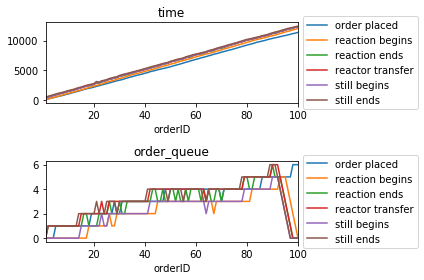

In [93]:
h.plot()

### Plotting one variable

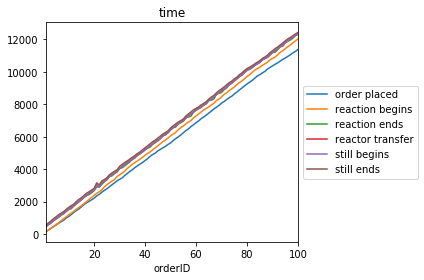

In [95]:
h.plot(['time'])

#### Distribution of waiting times for storage following reaction

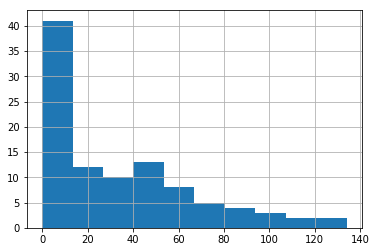

In [92]:
df = h.data('time')['reactor transfer'] - h.data('time')['reaction ends']
df.hist()

<!--NAVIGATION-->
< [Model Development in SimPy](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.04-Discrete-Event-Simulation-of-a-Batch-Process.ipynb) | [Contents](toc.ipynb) | [Spankys Pizzeria](http://nbviewer.jupyter.org/github/jckantor/CBE40455/blob/master/notebooks/02.06-Spankys-Pizzeria.ipynb) ><p><a href="https://colab.research.google.com/github/jckantor/CBE40455/blob/master/notebooks/02.05-Extracting_Information_from_Discrete-Event_Simulations.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://raw.githubusercontent.com/jckantor/CBE40455/master/notebooks/02.05-Extracting_Information_from_Discrete-Event_Simulations.ipynb"><img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>